# Career Longevity for NBA Rookies

In [37]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, plot_roc_curve

import autosklearn
import autosklearn.classification

## TODO build a training set and choose a classifier which maximize recall score returned by the score_classifier function
**Add data analysis**  
**Class imbalance**  
**Kfold inside autoML**  

## 1/ Data Exploration

### Data Introduction

This project will use data from two datasets: a rookies dataset and an active players dataset. The rookies dataset includes all of the rookies drafted between 1980 and 2015. The active players dataset lists the active players during each seeason from 1980 to 2017. Both datasets were taken from data.world. The active players dataset will be used to create a target column in the rookies dataset, which will then be used to model.
Rookies Data Dictionary

The following are the rookie year statistics that will be used to predict whether or not a player lasts 5 years in thee league: 'Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target'

    Year Drafted
    GP: games played during rookie season
    MIN: average minutes played per game
    PTS: average points per game
    FGM: average field goals made per game
    FGA: average field goals attempted per game
    FG%: average field goal percentage
    3P Made: average 3-point field goals made per game
    3PA: average 3-point field goals attempted per game
    3P%: 3-point percentage
    FTM: average free throws made per game
    FTA: average free throws attempted per game
    FT%: free throw percentage
    OREB: average offensive rebounds per game
    DREB: average defensive rebound per game
    REB: average total rebounds per game
    AST: average assists per game
    BLK: average blocks per game
    TOV: average turnovers per game
    EFF: a player's efficiency; EFF = (PTS + REB + AST + STL + BLK - Missed FG − Missed FT - TO) / GP


**Load dataset**

In [38]:
df = pd.read_csv("nba_logreg.csv")
df.head(10)
#DIre que les data sont deja clean

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
5,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,...,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0.0
6,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,50.0,...,1.8,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1.0
7,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,30.0,...,0.8,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1.0
8,Duane Cooper,65,9.9,2.4,1.0,2.4,39.2,0.1,0.5,23.3,...,0.5,71.4,0.2,0.6,0.8,2.3,0.3,0.0,1.1,0.0
9,Dave Johnson,42,8.5,3.7,1.4,3.5,38.3,0.1,0.3,21.4,...,1.4,67.8,0.4,0.7,1.1,0.3,0.2,0.0,0.7,0.0


In [39]:
df.drop(columns = ['Name'] , axis = 1, inplace=True)

**Find if the dataset contains duplicated rows and if yes removed them**  

In [40]:
print("\n","Number of duplicated rows : ", df.duplicated().sum(),"\n")
df.drop_duplicates(inplace=True)
print("\n","Number of duplicated rows after removing them: ", df.duplicated().sum(),"\n")


 Number of duplicated rows :  12 


 Number of duplicated rows after removing them:  0 



**Find nan values in the dataset**

In [41]:
print("\n","Rows containing nans values : \n", df[df.isnull().any(axis=1)],"\n")


 Rows containing nans values : 
      GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA  3P%  FTM  FTA   FT%  OREB  \
338  64  12.7   4.1  1.8  3.3  52.8      0.0  0.0  NaN  0.6  1.3  43.5   1.4   
340  53  10.8   2.8  1.3  2.1  60.4      0.0  0.0  NaN  0.3  0.8  42.5   0.9   
358  79  24.7  10.6  4.6  9.0  51.1      0.0  0.0  NaN  1.4  1.8  78.4   2.0   
386  60  11.9   3.2  1.2  2.4  48.6      0.0  0.0  NaN  0.8  1.1  75.8   0.7   
397  39   6.9   1.3  0.5  1.3  41.2      0.0  0.0  NaN  0.3  0.5  50.0   0.5   
507  59  18.2   6.1  2.6  4.7  55.6      0.0  0.0  NaN  0.8  1.5  55.1   1.5   
509  63  17.2   5.3  2.2  4.7  46.1      0.0  0.0  NaN  1.0  1.7  58.3   1.5   
510  71  17.0   4.9  2.1  4.2  50.3      0.0  0.0  NaN  0.7  1.0  70.8   1.5   
521  72  11.9   2.9  1.2  2.3  50.9      0.0  0.0  NaN  0.5  1.2  45.9   1.0   
559  56  18.9   4.7  2.1  4.6  45.0      0.0  0.0  NaN  0.5  0.7  67.5   1.1   

     DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
338   2.4  3.8  0.3  0.2  0.3  0.9 

**Conclusion:**  
**10 rows contain nan values but only on the 3P% column**

In [42]:
# Find duplicates and 
print(df.isna().sum().sum())
df.fillna(0.0, inplace=True)
print(df.isna().sum().sum())
print("\n","Rows containing nans values after removing them: \n", df[df.isnull().any(axis=1)],"\n")



10
0

 Rows containing nans values after removing them: 
 Empty DataFrame
Columns: [GP, MIN, PTS, FGM, FGA, FG%, 3P Made, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, TARGET_5Yrs]
Index: [] 



**Find the class imbalance ratio**  

1.0    824
0.0    504
Name: TARGET_5Yrs, dtype: int64

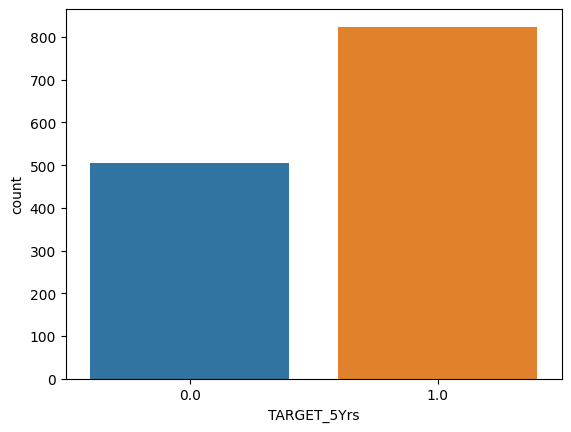

In [43]:
sns.countplot(data = df, x= 'TARGET_5Yrs')
counts = df['TARGET_5Yrs'].value_counts()
counts

**Conlusion:**  
**Here we can observe that there 62% of rows concerned players that stay at least 5 years in NBA**  
**We will see later how to tackle this class imbalance during the classifier training**

**Data repartition & Outliers analysis**

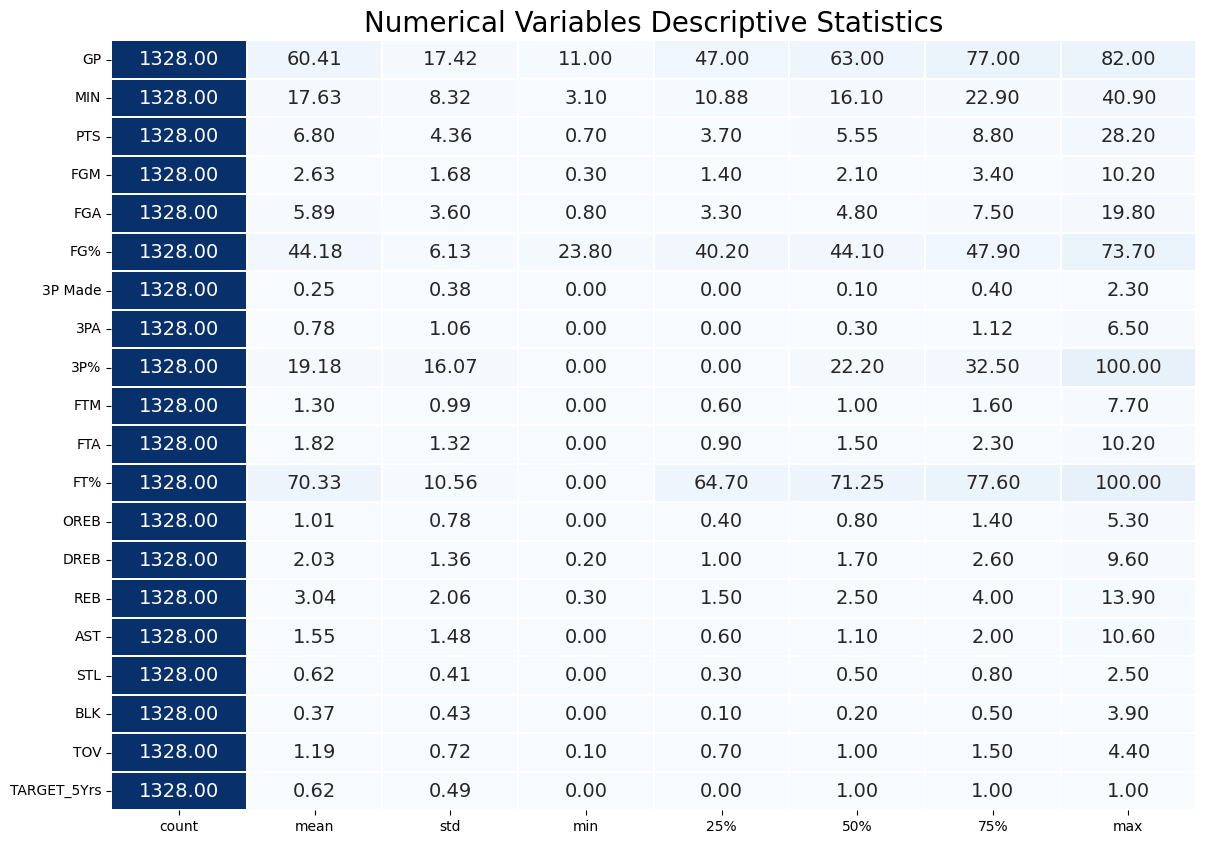

In [44]:
def describe_plot(df):
    describe = df.describe().T
    plt.figure(figsize = (14,10))
    sns.heatmap(describe,
                annot = True,
                cmap = "Blues",
                fmt= '.2f',
                linecolor = 'white',
                linewidths = 1.35,
                cbar = False,
                annot_kws = {"size": 14})
    plt.title("Numerical Variables Descriptive Statistics" , fontsize = 20)
    plt.show()
    
describe_plot(df)

In [45]:
def check_uniques(df):
    unique_values = []
    for col in df.columns:
        unique_values.append(len(df[col].unique()))
        
    unique_dict = {'unique_values' : unique_values}
    return pd.DataFrame(unique_dict , index=df.columns)
check_uniques(df)


,unique_values
GP,70
MIN,325
PTS,191
FGM,87
FGA,159
FG%,284
3P Made,23
3PA,54
3P%,254
FTM,59


In [46]:
def outlier_analysis(selection , df):
    columns = df.columns[:-1]
    # Outlier Box Plot
    if selection == 0:
        #sns.boxplot(df)
        for col in columns:
            plt.figure(figsize=(3,3))
            sns.boxplot(df[col])
    plt.show()
        
    # IQR Range Outliers
    if selection == 1:
        outlier_dict = dict()
        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3-Q1
            lower , upper = ('%.2f' % (Q1 - 1.5 * IQR)), ('%.2f' % (Q3 + 1.5 * IQR))
            outlier_dict[col] = (lower ,upper)
        return outlier_dict  

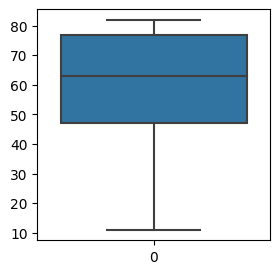

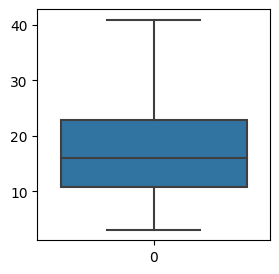

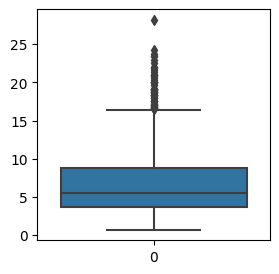

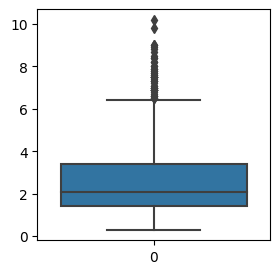

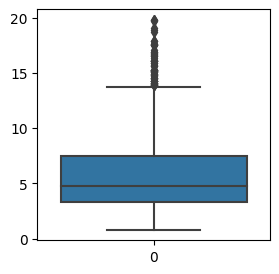

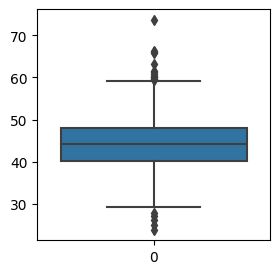

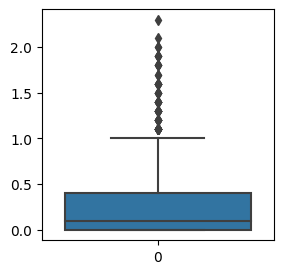

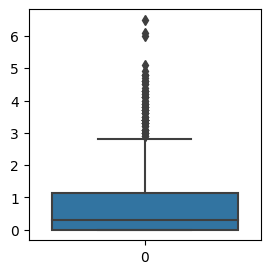

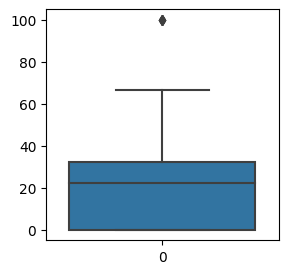

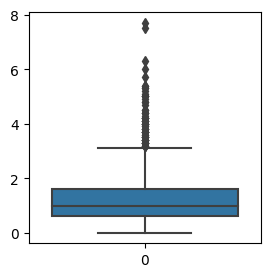

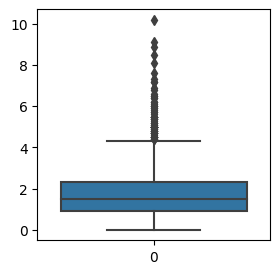

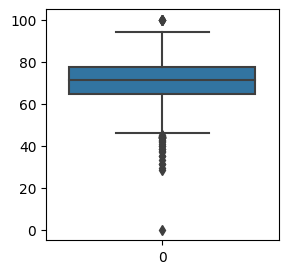

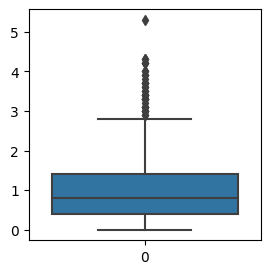

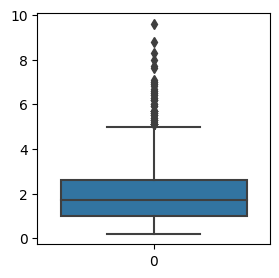

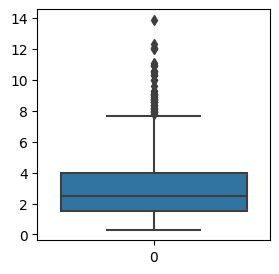

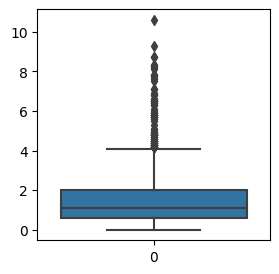

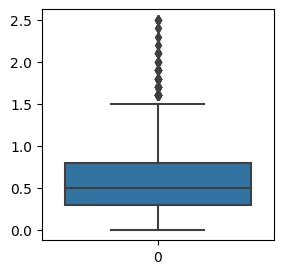

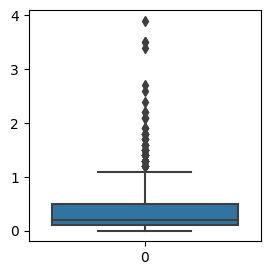

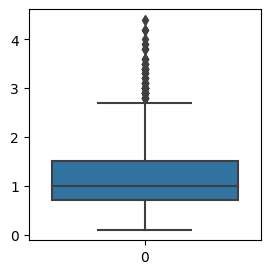

{'GP': ('2.00', '122.00'),
 'MIN': ('-7.16', '40.94'),
 'PTS': ('-3.95', '16.45'),
 'FGM': ('-1.60', '6.40'),
 'FGA': ('-3.00', '13.80'),
 'FG%': ('28.65', '59.45'),
 '3P Made': ('-0.60', '1.00'),
 '3PA': ('-1.69', '2.81'),
 '3P%': ('-48.75', '81.25'),
 'FTM': ('-0.90', '3.10'),
 'FTA': ('-1.20', '4.40'),
 'FT%': ('45.35', '96.95'),
 'OREB': ('-1.10', '2.90'),
 'DREB': ('-1.40', '5.00'),
 'REB': ('-2.25', '7.75'),
 'AST': ('-1.50', '4.10'),
 'STL': ('-0.45', '1.55'),
 'BLK': ('-0.50', '1.10'),
 'TOV': ('-0.50', '2.70')}

In [47]:
outlier_analysis(0 , df)
outlier_analysis(1 , df)

## Choose releavant features

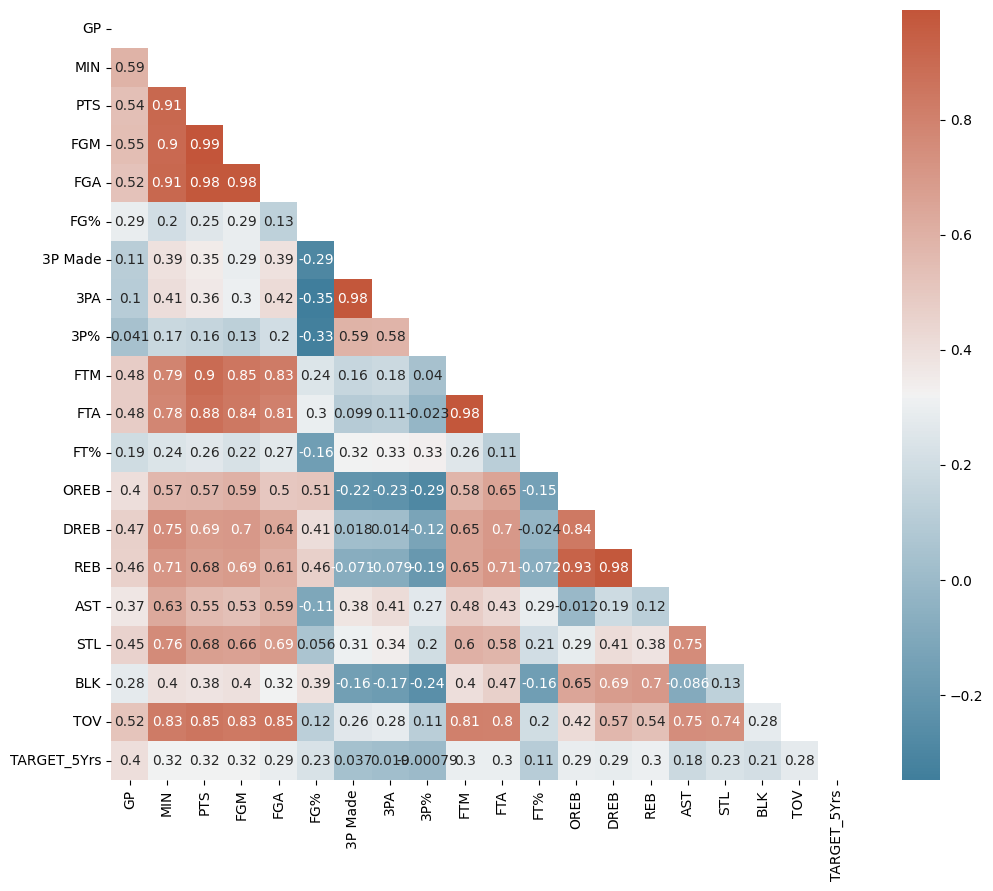

In [48]:
def correlation_coefficients(df):
    # Correlation between different variables
    corr = df.corr()
    # Set up the matplotlib plot configuration
    f, ax = plt.subplots(figsize=(12, 10))
    # Generate a mask for upper traingle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
    return corr
    
def variable_variances(df):
    return pd.DataFrame(df.var() , columns=['feature_variance'])

def corrFilter(x: pd.DataFrame, bound: float , corr_method  ='pearson'):
    xCorr = x.corr(method=corr_method)
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corr = correlation_coefficients(df)

In [49]:
attributes_corr_threshold  = corr.abs() > 0.95
dict_attributes_correlated = {column_name: [idx for idx, value in attributes_corr_threshold[column_name].items() if value and idx != column_name] for column_name in attributes_corr_threshold.columns}
dict_attributes_correlated


{'GP': [],
 'MIN': [],
 'PTS': ['FGM', 'FGA'],
 'FGM': ['PTS', 'FGA'],
 'FGA': ['PTS', 'FGM'],
 'FG%': [],
 '3P Made': ['3PA'],
 '3PA': ['3P Made'],
 '3P%': [],
 'FTM': ['FTA'],
 'FTA': ['FTM'],
 'FT%': [],
 'OREB': [],
 'DREB': ['REB'],
 'REB': ['DREB'],
 'AST': [],
 'STL': [],
 'BLK': [],
 'TOV': [],
 'TARGET_5Yrs': []}

**Considering that a two fetures are higly correlated with a score up to 0.95 or lower than -0.95:**  
PTS is higly correlated with MIN  
FGM is higly correlated with PTS  
FGA is higly correlated with PTS, FGM     
3PA is higly correlated with 3P MADE    
FTA is higly correlated with FTM    
REB is higly correlated with DREB  

**Correlation with TARGET_5Yrs is higher for:** 
    - 3PA than 3P Made: 3PA is to remove  
    - REB than DREB : DRED is to remove  
    - FGA than PTS and FGM : FGA is to remove  

**Correlation with TARGET_5Yrs is the same for:**  
    - FTA vs FTM but FTA is less correlated to other variables than FTM: FTM to remove  
    - PTS, MIN, FGM : As MIN and FGM aren't higly correlated but PTS is higly correlated to both, PTS is to remove 


In [14]:
df.drop(columns = ['PTS' , 'DREB', 'FTM', 'FGA' ,'3PA'] , axis = 1, inplace=True)

In [15]:
df.head()

,GP,MIN,FGM,FG%,3P Made,3P%,FTA,FT%,OREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,27.4,2.6,34.7,0.5,25.0,2.3,69.9,0.7,4.1,1.9,0.4,0.4,1.3,0.0
1,35,26.9,2.0,29.6,0.7,23.5,3.4,76.5,0.5,2.4,3.7,1.1,0.5,1.6,0.0
2,74,15.3,2.0,42.2,0.4,24.4,1.3,67.0,0.5,2.2,1.0,0.5,0.3,1.0,0.0
3,58,11.6,2.3,42.6,0.1,22.6,1.3,68.9,1.0,1.9,0.8,0.6,0.1,1.0,1.0
4,48,11.5,1.6,52.4,0.0,0.0,1.9,67.4,1.0,2.5,0.3,0.3,0.4,0.8,1.0


**Remove outliers outsique IQR**

In [16]:
def remove_outliers(df, outliers_dict):
    values = list(outliers_dict.values())
    keys = list(outliers_dict.keys())
    for index ,key in enumerate(keys):
        df = df[~((df[key] < float(values[index][0])) | (df[key] > float(values[index][1])))]

    return df      

outliers_dict = outlier_analysis(1 , df)
print("Number of row before outliers removal: ", len(df.index))
df = remove_outliers(df ,outliers_dict )

print("Number of row after outliers removal: ", len(df.index))



Number of row before outliers removal:  1328
Number of row after outliers removal:  998


In [22]:
df

,GP,MIN,FGM,FG%,3P Made,3P%,FTA,FT%,OREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,27.4,2.6,34.7,0.5,25.0,2.3,69.9,0.7,4.1,1.9,0.4,0.4,1.3,0.0
1,35,26.9,2.0,29.6,0.7,23.5,3.4,76.5,0.5,2.4,3.7,1.1,0.5,1.6,0.0
2,74,15.3,2.0,42.2,0.4,24.4,1.3,67.0,0.5,2.2,1.0,0.5,0.3,1.0,0.0
3,58,11.6,2.3,42.6,0.1,22.6,1.3,68.9,1.0,1.9,0.8,0.6,0.1,1.0,1.0
4,48,11.5,1.6,52.4,0.0,0.0,1.9,67.4,1.0,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,80,15.8,1.6,43.3,0.0,14.3,1.5,79.2,0.4,1.2,2.5,0.6,0.2,0.8,0.0
1336,68,12.6,1.5,35.8,0.1,16.7,1.0,79.4,0.4,1.5,2.3,0.8,0.0,1.3,1.0
1337,43,12.1,2.2,55.0,0.0,0.0,1.6,64.3,1.5,3.8,0.3,0.3,0.4,0.9,0.0
1338,52,12.0,1.7,43.9,0.0,10.0,1.8,62.5,0.2,0.7,2.2,0.4,0.1,0.8,1.0


## Training

In [18]:
# Extract features and label
df_values = df.drop(['TARGET_5Yrs'],axis=1)
labels = df['TARGET_5Yrs'].values.astype(int)

In [25]:
def build_automl(scorer):
    automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120, 
    per_run_time_limit=30, 
    metric = scorer,
    tmp_folder="/tmp/autosklearn_classification_recall_tmp",
    n_jobs=-1,
    memory_limit=6000,
    disable_evaluator_output=False,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 5},
    seed=50
    )
    return automl

In [24]:

confusion_mat = np.zeros((2,2))
recall, precision, f1 = 0, 0, 0
scaler = MinMaxScaler()
scorer = autosklearn.metrics.f1
X = scaler.fit_transform(df_values)
classifier = build_automl(scorer)
classifier.fit(X, labels)
print("CV RESULTS", classifier.cv_results_)
predicted_labels = classifier.predict(X)
confusion_mat = confusion_matrix(labels,predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
clf_report = classification_report(labels, predicted_labels , target_names=['0','1'])
print(clf_report)
print("Average Final confusion matrix: ", confusion_mat)
print("Average Final precision: ", precision)
print("Average Final f1: ", f1)
print("Average Final recall: ", recall)

CV RESULTS {'mean_test_score': array([0.71889682, 0.68571145, 0.6739164 , 0.67429426, 0.68956231,
       0.67543301, 0.64934669, 0.62253778, 0.        , 0.70529992,
       0.67896111, 0.69579066, 0.57412914, 0.6960716 , 0.69354098,
       0.70756425, 0.62866157, 0.64495326, 0.70012104, 0.64216697,
       0.        , 0.73331602, 0.7204765 , 0.62362219, 0.63699292,
       0.67285727, 0.73461933, 0.67324932, 0.        , 0.69249676,
       0.6783965 , 0.67124499, 0.67136463, 0.72381749, 0.        ,
       0.        , 0.68118774, 0.70775699, 0.        , 0.70688894,
       0.        , 0.68974539, 0.67212455, 0.71552392, 0.68087301,
       0.6604428 , 0.62703575, 0.57745142, 0.        , 0.        ,
       0.72132892, 0.72654926, 0.55113345, 0.        , 0.65144402,
       0.72214976, 0.71505816, 0.55429887, 0.        , 0.73357104,
       0.70816403, 0.72470682, 0.72233226, 0.6670648 , 0.67731273,
       0.72986244, 0.69033976, 0.60707884, 0.67216294, 0.59247884,
       0.        , 0.        , 

**Conlusion:** 
The trained classifier in fact maximize the recall score defined originilly in this test. Nevertheless, if we have a look on recall per class, we can observe that the model only learn to return '1' which means it's always saying that a player will stay at least five years in NBA. As often a metric at 100% means that something is wrong/overfitted.  

**Retrain to avoid overfitting on one class**  
**First use StratifiedKfold to get a similar repartition in each fold between class**  
**Secondly, train the model with weight to retain as if 50/50 repartition in data** TODO FIND in AutoSklearnClassifier 

## Fit on full data

In [29]:
classifier.refit(X, labels)
predicted_labels = classifier.predict(X)
confusion_mat = confusion_matrix(labels,predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
clf_report = classification_report(labels, predicted_labels , target_names=['0','1'])
print(clf_report)
print("Average Final confusion matrix: ", confusion_mat)
#print("Average Final precision: ", precision)
#print("Average Final f1: ", f1)
#print("Average Final recall: ", recall)

              precision    recall  f1-score   support

           0       0.74      0.55      0.63       434
           1       0.71      0.85      0.77       564

    accuracy                           0.72       998
   macro avg       0.72      0.70      0.70       998
weighted avg       0.72      0.72      0.71       998

Average Final confusion matrix:  [[239 195]
 [ 85 479]]
Average Final precision:  0.7106824925816023
Average Final f1:  0.7738287560581584
Average Final recall:  0.849290780141844


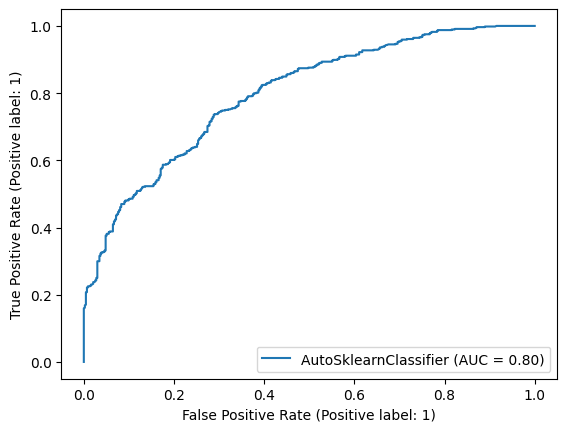

In [32]:
#Plot ROC Curve and calculate AUC
plot_roc_curve(classifier, X, labels)

In [30]:
print(classifier.sprint_statistics())

auto-sklearn results:
  Dataset name: 458402aa-7d6b-11ee-892c-b44506b29939
  Metric: f1
  Best validation score: 0.735333
  Number of target algorithm runs: 74
  Number of successful target algorithm runs: 61
  Number of crashed target algorithm runs: 10
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 0



In [27]:
print(classifier.leaderboard())

          rank  ensemble_weight                type      cost  duration
model_id                                                               
75           1             0.04  passive_aggressive  0.264667  1.183827
63           2             0.02  passive_aggressive  0.275293  1.861924
35           3             0.04                 qda  0.276183  1.750078
64           4             0.02                 lda  0.277668  1.262841
57           5             0.02                 qda  0.277850  1.205618
20           6             0.02  passive_aggressive  0.299879  3.846775
4            7             0.04            adaboost  0.326084  9.529531
44           8             0.34            adaboost  0.327875  3.022495
34           9             0.08  passive_aggressive  0.328635  2.781914
49          10             0.38        bernoulli_nb  0.422549  2.685307


In [28]:
print(classifier.show_models())

{4: {'model_id': 4, 'rank': 1, 'cost': 0.3260835977026717, 'ensemble_weight': 0.04, 'voting_model': VotingClassifier(estimators=None, voting='soft'), 'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f9d81ee32e0>, 'balancing': Balancing(random_state=50), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f9d83ed25b0>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f9d83fa4d90>, 'sklearn_classifier': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.046269426995092074, n_estimators=406,
                   random_state=50)}, {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f9df187c700>, 'balancing': Balancing(random_state=50), 'feature_preprocessor': <autosklearn.pipeline.components.featur

## Save model as joblib file

In [16]:
scaler_filename = '../infer/nba_rookie_mmscaler.save'
joblib.dump(scaler, scaler_filename) 

model_file_name = "../deploy/nba_rookie_autoMl_scorer_recall.joblib"
joblib.dump(classifier, model_file_name)

['../deploy/nba_rookie_autoMl_scorer_recall.joblib']